<a href="https://colab.research.google.com/github/AlineCrawf/data_science_projects_google_colab/blob/main/Diplom_mlflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
!pip install PyPDF2 fitz PyMuPDF pymorphy2 pandarallel 

  Created wheel for pandarallel: filename=pandarallel-1.5.2-cp37-none-any.whl size=18399 sha256=d1f0085fa4d6ea4a1cf576093611edc297aa5a4c2763e4224f5053041f9cb470
  Stored in directory: /root/.cache/pip/wheels/40/80/6d/d50fb72a8ce6a923fb10390fec9eaaa40b02d07a7ec05c9c05
Successfully built pandarallel


In [ ]:
#pip install --upgrade ipykernel

In [ ]:
#=== Read datasets =====================================
from PyPDF2 import PdfFileReader
import fitz

#=== Preprocessing =====================================
#import swifter
# Tokens and stopwords
import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

# Russian morph analyzer
import pymorphy2

#=== Work with dataframe ===============================
import pandas as pd
from numpy import array
# Max word in BOW/list
from collections import Counter

#=== Gensim ============================================
import gensim
from gensim import corpora
from gensim.models import Phrases, CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from sklearn.feature_extraction.text import CountVectorizer

#=== Visualisation =====================================
#import pyLDAvis
#import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
# Aplly progress
from tqdm import tqdm
tqdm.pandas()
from pandarallel import pandarallel

#import mlflow
#from mlflow.tracking import MlflowClient


In [ ]:
doc_list = ['9_a_m_2017_ru.pdf']
#

pdf_document = 'a.pdf'  # 5 - 217
text = list()
pages = list()

doc = fitz.open(pdf_document, filetype="pdf")
print("Исходный документ: ", doc)
print("\nКоличество страниц: %i\n\n------------------\n\n" % doc.pageCount)
print(doc.metadata)
for current_page in range(5, len(doc)):
    page = doc.loadPage(current_page)
    page_text = page.getText("text")    
    pt = sent_tokenize(page_text.lower(), language="russian")
    print(pt)
    text.extend(pt)
    pages.extend([current_page]*len(pt))
doc.close()



Исходный документ:  Document('Umnov-AnGeom-i-LinAl-arph0duocc9.pdf')

Количество страниц: 545

------------------


{'format': 'PDF 1.5', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'creator': "Tracker's PDF-Tools", 'producer': 'PDF-XChange (PDFTools3.exe v3.60.0108) (Windows)', 'creationDate': '', 'modDate': '', 'trapped': '', 'encryption': None}
['оглавление                                                                                                5 \n \n \nглава 7. \nлинейное пространство ..................................... \n \n235 \n§ 7.1. определение линейного пространства ................ \n235 \n§ 7.2. линейная зависимость, размерность и базис в \nлинейном пространстве ........................................ \n \n239 \n§ 7.3. подмножества линейного пространства ............. \n244 \n§ 7.4. операции с элементами линейного пространст-\nва в координатном представлении ....................... \n \n251 \n§ 7.5. изоморфизм линейных пространств ...................

In [ ]:
#pages.clear()
#print(pages)
df = pd.DataFrame({"idx":range(1,len(text)+1), "text": text, "page":pages})
df

,idx,text,page
0,1,оглавление ...,5
1,2,ортогонализация \nбазиса ........................,5
2,3,6 аналитическа...,6
3,4,среднее значение и \nдисперсия эрмитова операт...,6
4,5,443 \nприл. 1.2 \nэллипс и его свойства .........,6
...,...,...,...
3937,3938,����� 400 ���.,544
3938,3939,�����\n���������������������������������������...,544
3939,3940,"������������, ����������������., 9\ne-mail: ri...",544
3940,3941,"��������, �.13, ���.",544


In [ ]:
print(df.loc[[19]])

    idx text  page
19   20    .     5


/home/aline/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def morph_tokens(tokens):
    morph = pymorphy2.MorphAnalyzer()
    return [morph.parse(token)[0].normal_form for token in  tokens ]

def filter_stop_words(text):      
    text = text.replace('-\n', '').replace('\n', ' ')
    text = re.sub(r'[^\w\s]+|[\d]+', r'',text)
          
    tokens = word_tokenize(text, language="russian")
    stop_words = stopwords.words("russian")
    punctuation = [".",'«','»',',', "a",";",'{','}', '(',')','x',':','–','х',">","<"]
    return list(filter(lambda token: token not in stop_words and token not in punctuation and len(token)>1, tokens ))#

def preprocessing(text):
    tokens = filter_stop_words(text)
    tokens = morph_tokens(tokens) 
    #print(' '.join(tokens))
    return ' '.join(tokens) 

def max_word(text):    
    
    morph_token = morph_tokens(text)
    counter = collections.Counter(lst)    
    return  max(counter.items(), key=operator.itemgetter(1))[0]
df1 = df

In [ ]:
pandarallel.initialize()

df1['text'] = df1['text'].parallel_apply(lambda x: preprocessing(x))

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
print(df1)

       idx                                               text  page
0        1  оглавление глава линейный пространство определ...     5
1        2                              ортогонализация базис     5
2        3  аналитический геометрия линейный алгебра коорд...     6
3        4  средний значение дисперсия эрмитовый оператор ...     6
4        5  прил эллипс свойство прил гипербола свойство п...     6
...    ...                                                ...   ...
3937  3938                                                      544
3938  3939                                                      544
3939  3940  email riomailmiptru __________________________...   544
3940  3941                                                      544
3941  3942                                                      544

[3942 rows x 3 columns]


In [ ]:
df.to_csv('preproc_Umnov-AnGeom-i-LinAl-arph0duocc9.csv', encoding="utf-8")

In [ ]:

text_clean= []
for index, row in df.iterrows():
        text_clean.append(row['text'].split())


'''
tc = text_clean
text_clean = []
stop_words = stopwords.words("russian")
punctuation = [".",'«','»',',', "a",";",'{','}', '(',')','x',':','–','х',">","<"]


for t in tc:
    t = list(filter(lambda token: token is not '◄' and len(token)>2 and token not in punctuation and t not in stop_words, t ))
    text_clean.append(t)
'''

bigram = Phrases(text_clean) # Создаем биграммы на основе корпуса
trigram = Phrases(bigram[text_clean])# Создаем триграммы на основе корпуса

for idx in range(len(text_clean)):
    for token in bigram[text_clean[idx]]:
        if '_' in token:
            # Токен это би грамма, добавим в документ.
           # print('би грамма:',token)
            text_clean[idx].append(token)
    for token in trigram[text_clean[idx]]:
        if '_' in token:
            #print('три грамма:',token)
            # Токен это три грамма, добавим в документ.
            text_clean[idx].append(token)
            


/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")



In [ ]:

dictionary = Dictionary(text_clean)
dictionary.filter_extremes(no_below=10, no_above=0.1)
#Создадим словарь и корпус для lda модели
corpus = [dictionary.doc2bow(doc) for doc in text_clean]
print('Количество уникальных токенов: %d' % len(dictionary))
print('Количество документов: %d' % len(corpus))

Количество уникальных токенов: 644
Количество документов: 3942


In [ ]:

model=LdaMulticore(corpus=corpus,id2word=dictionary, num_topics=2)
#model.show_topics()
model.print_topics()

[(0,
  '0.027*"линейный_алгебра" + 0.020*"аналитический_геометрия" + 0.018*"оператор" + 0.017*"элемент" + 0.013*"алгебра" + 0.011*"евклид_пространство" + 0.011*"геометрия" + 0.010*"уравнение" + 0.010*"аналитический_геометрия_линейный_алгебра" + 0.010*"аналитический"'),
 (1,
  '0.021*"квадратичный_функционал" + 0.014*"собственный_вектор" + 0.013*"функционал" + 0.012*"оператор" + 0.012*"ортонормированный_базис" + 0.012*"вид" + 0.011*"теорема_доказать" + 0.010*"элемент" + 0.010*"число" + 0.009*"система"')]

In [ ]:

model_list = []
model_list.clear()

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
	Подсчет c_v когерентности для различного количества тем
	dictionary : Gensim словарь
	corpus : Gensim корпус
	texts : Список текста
	limit : Максимальное количество тем
	
	model_list : Список LDA моделей
	coherence_values :Когерентности, соответствующие модели LDA с количеством тем
    """
    coherence_values = []
    
    for num_topics in range(start, limit, step):
        model=LdaMulticore(corpus=corpus,id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values
	
# Вызовем функцию и посчитаем
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=text_clean, start=2, limit=40, step=1)

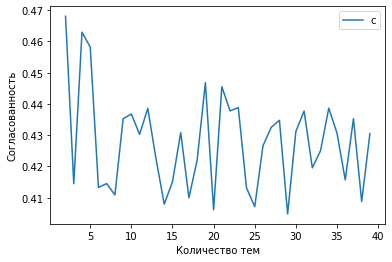

(0.4680686547069004, 2)

In [ ]:
limit=40; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Количество тем")
plt.ylabel("Согласованность")
plt.legend(("coherence_values"), loc='best')
plt.show()

max(zip(coherence_values, x))

In [ ]:
# Сохраняем модель
model.save('best_model.lda')
# Сохраняем словарь
for m in model_list:
  print(m.print_topics())
corpora.Dictionary.save(dictionary, "dictionary.dict")
# Сохраняем корпус
corpora.BleiCorpus.save_corpus(fname="corpus.lda-c",corpus= corpus)
# Сохраняем выражения 
bigram.save('bigram.phs')
trigram.save('trigram.phs')


[(0, '0.019*"квадратичный_функционал" + 0.018*"аналитический_геометрия" + 0.015*"оператор" + 0.015*"линейный_алгебра" + 0.015*"собственный_вектор" + 0.011*"функционал" + 0.009*"элемент" + 0.009*"который" + 0.009*"определение" + 0.009*"алгебра"'), (1, '0.016*"линейный_алгебра" + 0.016*"элемент" + 0.015*"ортонормированный_базис" + 0.015*"оператор" + 0.013*"вид" + 0.012*"евклид_пространство" + 0.011*"уравнение" + 0.011*"число" + 0.010*"аналитический_геометрия" + 0.010*"теорема_доказать"')]
[(0, '0.021*"оператор" + 0.013*"доказательство" + 0.013*"линейный_комбинация" + 0.011*"вид" + 0.011*"элемент" + 0.010*"линейный_пространство" + 0.010*"матрица_переход" + 0.010*"равенство" + 0.009*"система" + 0.008*"скалярный_произведение"'), (1, '0.028*"линейный_алгебра" + 0.024*"аналитический_геометрия" + 0.023*"квадратичный_функционал" + 0.016*"теорема_доказать" + 0.016*"элемент" + 0.014*"функционал" + 0.013*"алгебра" + 0.013*"ортонормированный_базис" + 0.012*"геометрия" + 0.012*"аналитический"'), (2,

In [ ]:
class LdaPredictor():
    
    def __init__(self, lda_path, dict_path, bigram_path, trigram_path):
        """
        lda_path - путь к lda модели
        dict_path - путь к словарю 
        bigram_path - путь к биграммам
        trigram_path - путь к триграммам
        
        param: lda_path str
        param: dict_path str
        param: bigram_path str
        param: trigram_path str
        """
        self.dictionary = corpora.Dictionary.load(dict_path)
        self.lda = LdaMulticore.load(lda_path)
        self.bigram_path = bigram_path
        self.trigram_path = trigram_path

    def morph_tokens(self, tokens):
        morph = pymorphy2.MorphAnalyzer()
        return [morph.parse(token)[0].normal_form for token in  tokens ]

    def filter_stop_words(self, text):      
        text = text.replace('-\n', '').replace('\n', ' ')
        text = re.sub(r'[^\w\s]+|[\d]+', r'',text)
              
        tokens = word_tokenize(text, language="russian")
        stop_words = stopwords.words("russian")
        punctuation = [".",'«','»',',', "a",";",'{','}', '(',')','x',':','–','х',">","<"]
        return list(filter(lambda token: token not in stop_words and token not in punctuation and len(token)>1, tokens ))

        
    def preprocessing(self,text):
        tokens = self.filter_stop_words( text)
        tokens = self.morph_tokens( tokens)       
        return ' '.join(tokens) 

    
    def bigram(self, text):
        bigram = Phrases.load(self.bigram_path)
        trigram = Phrases.load(self.trigram_path)
        text_clean = text
        for idx in range(len(text_clean)):
            for token in bigram[text_clean[idx]]:
                if '_' in token:
                    text_clean[idx].append(token)
            for token in trigram[text_clean[idx]]:
                if '_' in token:
                    text_clean[idx].append(token)
        return text_clean
    def topics(self):      
        for topic in self.lda.print_topics():
            print(topic)


    def predict(self, text):
        clean_text = self.preprocessing(text).split()
        bigram = self.bigram([clean_text])
        new_review_bow = self.dictionary.doc2bow(bigram[0])
        new_review_lda = self.lda[new_review_bow]
        return sorted(new_review_lda, reverse=True, key =lambda l: l[1])

In [ ]:
import regex

lda_path = "best_model.lda"
dict_path = "dictionary.dict"
bigram_path = "bigram.phs"
trigram_path = "trigram.phs"
lda = LdaPredictor(lda_path, dict_path,  bigram_path, trigram_path)
text = """В данной главе рассматриваются некоторые классы задач, имеющие важное значение в прикладных разделах математики, таких, как
математическая физика, теория оптимального управления, математическая экономика, вычислительная математика и т.д., причем общим
для этих задач является использование в процессе их решения понятий и методов различных разделов линейной алгебры. """
predict = lda.predict(text)
lda.topics()
print(predict)

#model.print_topics()

(0, '0.027*"линейный_алгебра" + 0.020*"аналитический_геометрия" + 0.018*"оператор" + 0.017*"элемент" + 0.013*"алгебра" + 0.011*"евклид_пространство" + 0.011*"геометрия" + 0.010*"уравнение" + 0.010*"аналитический_геометрия_линейный_алгебра" + 0.010*"аналитический"')
(1, '0.021*"квадратичный_функционал" + 0.014*"собственный_вектор" + 0.013*"функционал" + 0.012*"оператор" + 0.012*"ортонормированный_базис" + 0.012*"вид" + 0.011*"теорема_доказать" + 0.010*"элемент" + 0.010*"число" + 0.009*"система"')
[(0, 0.9545674), (1, 0.045432657)]


/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")



In [ ]:
pyLDAvis.enable_notebook()
data = pyLDAvis.gensim.prepare(model, corpus, dictionary)

In [ ]:
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment('test experiment')

with mlflow.start_run():
    # Логирование модели и параметров
    mlflow.log_param(
        'Topic count',5)
    mlflow.log_param(
        'Coherence value',0.4063551879884188
    )
    mlflow.sklearn.log_model(
        model,
        artifact_path = '',
        registered_model_name='Test model ')
    mlflow.end_run()

Registered model 'Test model ' already exists. Creating a new version of this model...
2021/06/04 13:10:27 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: Test model , version 2
Created version '2' of model 'Test model '.
